In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
from regrid import regrid
import itertools
import cartopy.crs as ccrs
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
datapath = '/Users/carmennab/Dropbox/met_office/data/experiments/FOAM_grid/'
base = Dataset(datapath+'rosie_UCL_BASELINE_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_r243541_dcarneir.nc')
unc = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_NEW_OBERR_r243541_dcarneir.nc')

foam_lats = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lat_cent.npy')
foam_lons = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lon_cent.npy')

In [3]:
months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr']
days = [np.arange(0,32),
 np.arange(32,61),
 np.arange(61,92),
 np.arange(92,123),
 np.arange(123,151),
 np.arange(151,182),
 np.arange(182,212)]

nums = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

### thermodynamic volume change

In [5]:
rho_fyi = 916.7
rho_myi = 882
icetype = np.array(Dataset('/Users/carmennab/Dropbox/met_office/data/auxiliary/icetype.nc')['Ice Type'])
icetype[icetype==2] = rho_fyi
icetype[icetype==3] = rho_myi

In [6]:
sits = [unc,base]
names = ['UNC','BASE']
vols = {}

for sit,name in zip(sits,names):
    area = np.array(sit['area'])
    rate = np.array(sit['sidmassth'])
    conc = np.array(sit['siconc'])

    sit = np.array(sit['sivolu'])
    rate[np.isnan(sit)] = np.nan

    dens = icetype.copy()
    dens[np.isnan(dens)&~np.isnan(rate)] = rho_fyi 
    mass = rate * (area * conc) * 86400 # convert from rate per second to total mass per day
    vol = (mass / dens) 
    vols[name] = vol

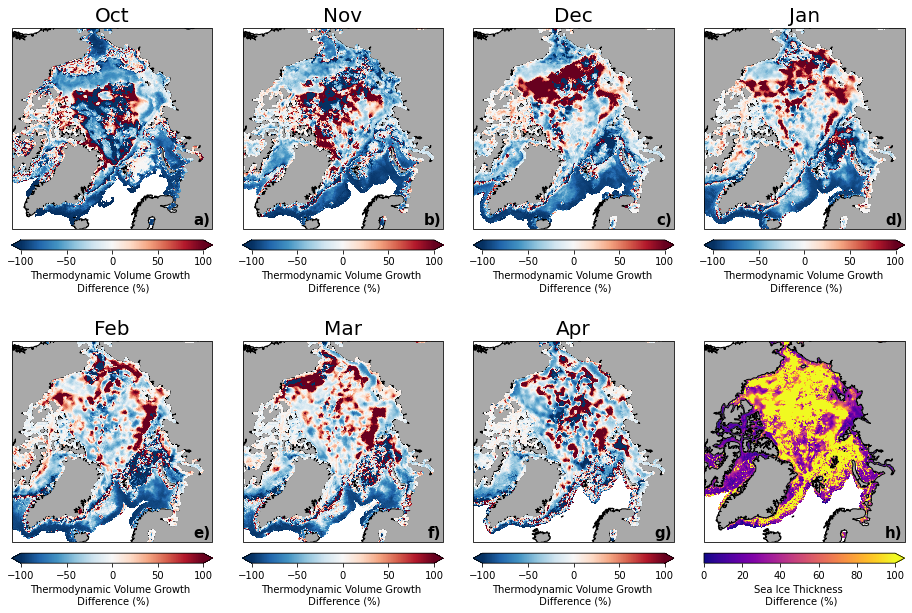

In [7]:
fig = plt.figure(figsize=(16,11))
spec = gridspec.GridSpec(ncols=4, nrows=2, hspace=0.1, wspace=0.15)

stdevs = []

### monthly SIT change
for count, month in enumerate(months):
    
    unc_mean = np.nanmean(np.array(vols['UNC'])[days[count]],axis = 0)
    base_mean = np.nanmean(np.array(vols['BASE'])[days[count]],axis = 0)
    perc_diff = ((unc_mean-base_mean)/base_mean)*100
    perc_diff[np.isinf(perc_diff)] = np.nan
    stdevs.append(perc_diff)
    ax = fig.add_subplot(spec[count],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(foam_lons,foam_lats,perc_diff[:-1,:-1],cmap='RdBu_r',vmin=-100,vmax=100,
                          transform=ccrs.PlateCarree())  
    a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04, extend='both') 
    a.set_label('Thermodynamic Volume Growth \n Difference (%)',fontsize='medium')
    ax.set_title(month, fontsize=20) 
    ax.text(0.99, 0.02, nums[count], fontsize=15, ha= 'right', transform = ax.transAxes,fontweight='bold')

### standard deviation
stdev = np.std(stdevs,axis = 0)

ax = fig.add_subplot(spec[7],projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax.pcolormesh(foam_lons,foam_lats,stdev[:-1,:-1],cmap='plasma',vmin=0,vmax=100,
                      transform=ccrs.PlateCarree())   
ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
ax.coastlines()
a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04, extend='max') 
a.set_label('Sea Ice Thickness \n Difference (%)',fontsize='medium')
ax.text(0.99, 0.02, nums[7], fontsize=15, ha= 'right', transform = ax.transAxes,fontweight='bold')

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/supp_figs/tmc_maps_base_vs_unc.png',
            dpi=400, bbox_inches="tight")